# Model inference II

Based on the variational posterior of the parameter $\beta$ and $\rho$, we aim to have following inference from the model. 

+ Species similarity based on the species specific latent vector $\beta$ (cosine distance used)
+ Identify positive  interaction among species using positive entries in in the interaction matrix $\rho^{T}\beta$
+ Identify negative  interaction among species using negative entries in in the interaction matrix $\rho^{T}\beta$



In [170]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
#import vb_stan as vbfun
#import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import copy 
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import kneighbors_graph
#from fa2 import ForceAtlas2
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
# 🔥 Fix: Add utils/ directory where vb_stan.py and sub_fun.py are located
sys.path.append("../utils")  # Ensure utils is in module search path

# ✅ Import vb_stan and sub_fun
try:
    import vb_stan as vbfun
    import sub_fun as sf
    print("✅ Successfully imported vb_stan and sub_fun!")
except ModuleNotFoundError as e:
    print(f"❌ Error: {e}")


# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1


# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"
elif data == "new" and setting == 1:
    figfol = "./plots4/"


if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

if data == "original": 
    data_path = "data_op"
else: 
    data_path = "data_new"
if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

# ✅ Fix: Execute data_file.py (after setting correct paths)
try:
    exec(open('./data_file.py').read())  # Execute the script
    print("✅ Successfully executed data_file.py")
except Exception as e:
    print(f"❌ Error executing data_file.py: {e}")

# Update plot settings
plt.rcParams.update(plt.rcParamsDefault)
params = {
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'figure.dpi': 200,
    'ytick.labelsize': 12
}
plt.rcParams.update(params)

%matplotlib inline

distinct_colp = ["maroon","brown","olive", "teal", "lightgreen", "red", "orange",\
 "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",\
 "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",\
     "cornflowerblue","olivedrab",'greenyellow','peru','darkslateblue']


✅ Successfully imported vb_stan and sub_fun!
📂 Folder already exists: ./plots3/
📂 Folder already exists: ./plots3/
Satellite data loaded: (180, 10)


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


✅ Successfully executed data_file.py


In [171]:
# Call the output from the fitted model:
import glob
import pickle
import os

# Define folder path
folname = '../src'
#fname_best = '18_52_model_nb_cvtest.pkl' #original data ndc
fname_best = '30_61_model_nb_cvtest.pkl' #new data nc 
#fname_best = '30_68_model_nb_cvtest.pkl' #original data dc
#fname_best = '30_17_model_nb_cvtest.pkl' #new data coupling 

# Load fitted model output
with open(os.path.join(folname, fname_best), 'rb') as f:
    [holdout_mask, llpd, n_test, l, m_seed, sp_mean, sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(f)

#with open(os.path.join(folname, fname_best), 'rb') as f:
#    [holdout_mask, _1, _2, _3, l,m_seed,sp_mean,\
#                 sp_var, h_prop, uid, mtype,\
#                 Yte_fit, cv_test, Y, muest, Yte_cv, _4, _5] = pickle.load(f)
# Construct filenames using uid and m_seed
fname_ot = os.path.join(folname, f"{uid}_{m_seed}_model_nb.pkl")
sample_fname = os.path.join(folname, f"{uid}_{m_seed}_sample_model_nb_cvtest.pkl")

# Load results
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)

# Load sample model output
with open(sample_fname, 'rb') as f:
    [Yte_sample, Yte_cv] = pickle.load(f)


parma_mean  = dict(vbfun.vb_extract_mean(results))

In [172]:
import pandas as pd
import numpy as np

if data == "original": 
# Load taxonomy file
    tax_name = pd.read_csv(f'../data/{data_path}/species_tax.csv')
    tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
    tax_name = tax_name[1:]  # Drop header row if repeated
    tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
    tax_name.columns.values[1] = 'Label'
    tax_name.to_csv('node_otu.csv', index=False)
    tax_name[['Id']] = tax_name[['Id']].astype(np.int64)
    tax_name = tax_name.replace(pd.NA, 'Empty').replace(np.nan, 'Empty')

    # Extract most specific taxonomy level as Name
    temx = tax_name.iloc[:, :8].replace('Empty', '')
    species_name = []
    for i in range(temx.shape[0]):
        a = temx.iloc[i].values
        for j in range(len(a)-1, -1, -1):
            if len(a[j]) > 0:
                species_name.append(temx.columns[j][0].lower() + '_' + a[j])
                break
    tax_name['Name'] = np.array(species_name)

    # Add Abundance (assumes Y is defined)
    tax_name['Abundance'] = Y.sum(axis=0)

    # -------------------------------
    # Use different logic based on `data` flag
    # -------------------------------

    tem = pd.read_csv(f'../data/{data_path}/species_tax_anot.amended.csv').iloc[:, [1, 12]]
    tax_name = tax_name.merge(tem, on='Label')
    tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

    # Group rare ECR categories into 'Other'
    ind_var = tax_name['ECR'].values
    vals, counts = np.unique(ind_var, return_counts=True)
    sorted_vals = vals[(-counts).argsort()]
    common_vals = sorted_vals[:np.sum(counts > 10)]
    rare_vals = np.setdiff1d(vals, common_vals)
    tax_name['ECR'] = np.where(np.isin(ind_var, rare_vals), 'Other', ind_var)

    # ✅ Show summary
    print("✅ Taxonomic annotation completed.")
    print("Top ECR categories:\n", tax_name['ECR'].value_counts().head())
else:
    # Load species taxonomy
    tax_name = pd.read_csv(f'../data/{data_path}/species_tax.csv')

    # Clean up
    tax_name = tax_name.rename(columns={'Unnamed: 0': 'Label'})
    tax_name['Label'] = tax_name['Label'].str.strip()  # 🔑 Remove any whitespace
    tax_name = tax_name.replace(pd.NA, 'Empty').replace(np.nan, 'Empty')
    tax_name.to_csv('node_otu.csv', index = False) 
    species_name = []
    # Extract most specific taxonomy
    temx = tax_name.iloc[:, :8].replace('Empty', '')

    for i in range(temx.shape[0]):
        a = temx.iloc[i,:].values
        for j in range(a.shape[0]-1,-1,-1):
            if len(a[j]) > 0:
                species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
                break;           
    species_name = np.array(species_name)  
    tax_name['Name'] = species_name

    tax_name.loc[:Y.shape[1]-1, 'Abundance'] = Y.sum(axis=0)

    tax_name['Id'] = tax_name['Label'].str.extract(r'(\d+)').astype(int)

    tax_name = tax_name.replace(np.nan,'Empty')
    #tem = pd.read_csv(f'../data/{data_path}/species_tax_anot.amended.csv')[['name', 'erc']]
    tem = pd.read_csv(f'../data/{data_path}/otu_new_annotation(1).csv')[['name', 'erc']]
    tax_name = tax_name.merge(tem, left_on='Label', right_on='name')


<font color=blue>**Perform the softmax regression based on the latent characteristic of the species specific parameters $\beta$** </font>

 - Here our aim is to find subset of 1378 species that are efficiently charcterized in terms of the species specific latent vector $\beta$. 

In [173]:
## Prepare response matrix for softmax regression 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from collections import Counter
if data == "original":
    tax_name2 = copy.copy(tax_name) 
    encode_dict = [[val,i] for i,val in enumerate(np.unique(tax_name2['ECR'].values)) ]
    ord_enc = OrdinalEncoder()
    ord_enc.fit(tax_name2['ECR'].values.reshape(-1,1))
    tax_name2["ECR_code"] = ord_enc.fit_transform(tax_name2['ECR'].values.reshape(-1,1))
    cat_val = tax_name2["ECR_code"].values.astype(np.int)


    sp_feature = parma_mean['L_sp']   
    #sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)
    softReg = LogisticRegressionCV(random_state=10, multi_class = 'multinomial', max_iter = 2000)
    clf = softReg.fit(sp_feature, cat_val)
    cat_pred = clf.predict(sp_feature)
    tax_name2["ECR_pred"]  = ord_enc.inverse_transform(cat_pred.reshape(-1,1))
else:
    tax_name2 = copy.copy(tax_name) 
    encode_dict = [[val,i] for i,val in enumerate(np.unique(tax_name2['erc'].values)) ]
    ord_enc = OrdinalEncoder()
    ord_enc.fit(tax_name2['erc'].values.reshape(-1,1))
    tax_name2["erc_code"] = ord_enc.fit_transform(tax_name2['erc'].values.reshape(-1,1))
    cat_val = tax_name2["erc_code"].values.astype(np.int)
    # Align shapes by trimming the last label
    sp_feature = parma_mean['L_sp']   
    #sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)
    cat_val = cat_val[:sp_feature.shape[0]]
    class_counts = Counter(cat_val)
    min_count = 5
    # Build mask to keep only frequent classes
    keep_mask = np.isin(cat_val, [k for k,v in class_counts.items() if v >= min_count])
    # Filter features and labels
    sp_feature_filtered = sp_feature[keep_mask]
    cat_val_filtered = cat_val[keep_mask]
    cat_val_filtered = cat_val_filtered[:sp_feature_filtered.shape[0]]
    #label_enc = LabelEncoder() 
    #cat_val_reencoded = label_enc.fit_transform(cat_val)
    softReg = LogisticRegressionCV(random_state=10, multi_class = 'multinomial',solver='lbfgs',max_iter = 2000, cv= 3)
    clf = softReg.fit(sp_feature_filtered, cat_val_filtered)
    cat_pred = clf.predict(sp_feature)
    tax_name2 = tax_name2.iloc[:-1].copy()
    tax_name2["erc_pred"]  = ord_enc.inverse_transform(cat_pred.reshape(-1,1))


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [174]:
# Show confusion matrix and present the 
if data == "original": 
    confusion_matrix = pd.crosstab(tax_name2['ECR'], tax_name2["ECR_pred"],\
                                rownames=['Actual'], colnames=['Predicted'],\
                                    dropna = False, normalize = 'index')
else:
    confusion_matrix = pd.crosstab(tax_name2['erc'], tax_name2["erc_pred"],\
                                rownames=['Actual'], colnames=['Predicted'],\
                                    dropna = False, normalize = 'index')
# fig, ax = plt.subplots(figsize=(15, 10))
# sns.heatmap(confusion_matrix, annot=True, ax = ax, fmt = '')

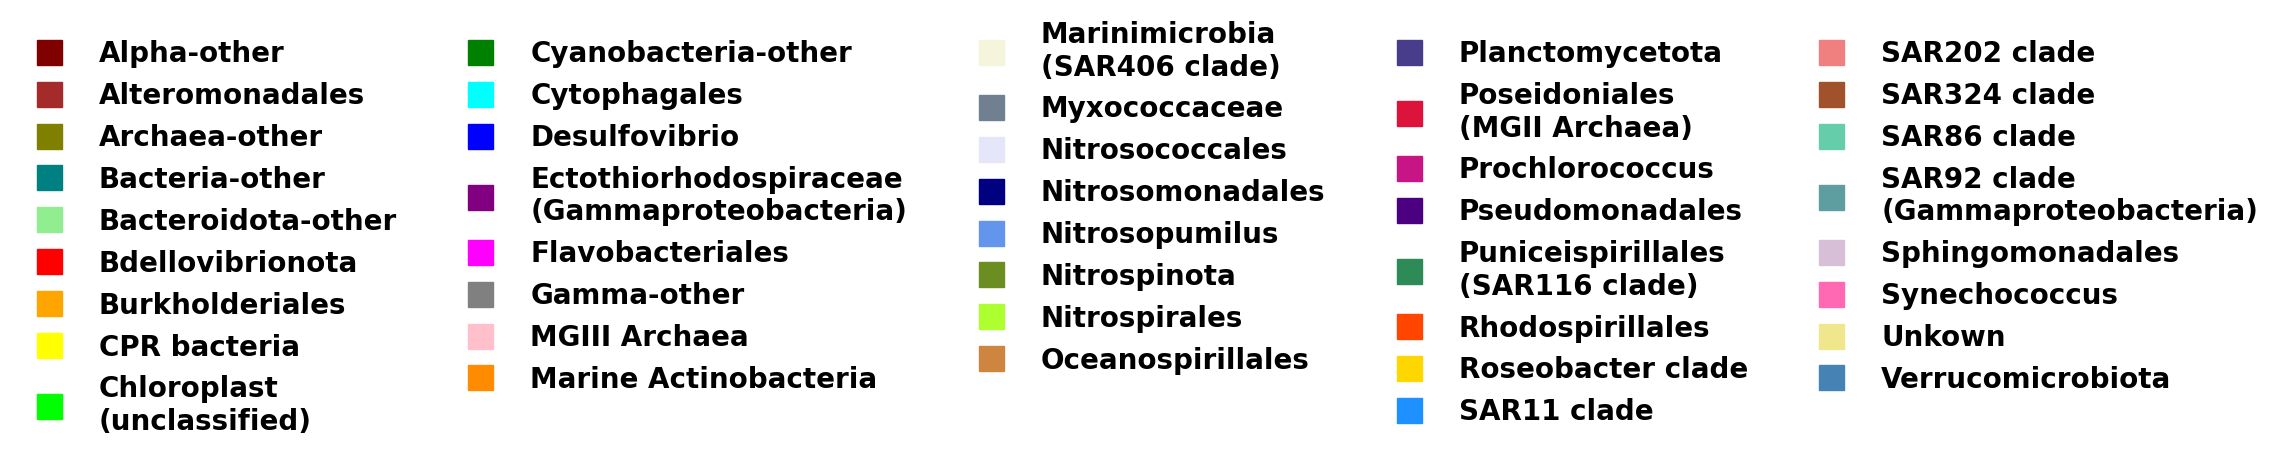

In [175]:
## Select species that are efficiently characterized in terms of the latent parameter $\beta$
## selected_species = [i for i in list(confusion_matrix.columns) if confusion_matrix.loc[i,i] >= 0.00]
if data == "original":
    selected_species = list(np.unique(tax_name2['ECR']))
    #selected_species.remove('Other')
    selected_species_index = tax_name['ECR'].isin(selected_species).values
    species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    label = [i.replace(' (', '\n(') for i in selected_species]   
    fig, ax  = plt.subplots(dpi = 100, figsize = (25,4))
    handles = [f("s", species_col_dict[i]) for i in selected_species]
    plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=5,markerscale=3., fontsize=18,  prop={'size': 20})
    plt.gca().set_axis_off()
    plt.show()
    fig.savefig(figfol + 'MI2Anot.png')
else:
    distinct_colp = [
    "maroon", "brown", "olive", "teal", "lightgreen", "red", "orange",
    "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",
    "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",
    "cornflowerblue", "olivedrab", "greenyellow", "peru", "darkslateblue",
    "crimson", "mediumvioletred", "indigo", "seagreen", "orangered", "gold",
    "dodgerblue", "lightcoral", "sienna", "mediumaquamarine", "cadetblue",
    "thistle", "hotpink", "khaki", "steelblue"]
    selected_species = list(np.unique(tax_name2['erc']))
    #selected_species.remove('Other')
    selected_species_index = tax_name['erc'].isin(selected_species).values
    species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    label = [i.replace(' (', '\n(') for i in selected_species]   
    fig, ax  = plt.subplots(dpi = 100, figsize = (25,4))
    handles = [f("s", species_col_dict[i]) for i in selected_species]
    plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=5,markerscale=3., fontsize=18,  prop={'size': 20})
    plt.gca().set_axis_off()
    plt.show()
    fig.savefig(figfol + 'MI2Anot.png')

### <font color=blue>Similarity among speecies </font>

+ K nearest neighbour graph to show similarity among species 
+ Modularity analysis to mark cluster of species and efficiently depicts their groupings

In [176]:
## Prepare k-nearest neighbour graph 
if data == "original":
    def most_important(G,n_sel):
        ranking = nx.betweenness_centrality(G).items()
        ranking = sorted(list(ranking),key=lambda x: x[1], reverse=True)
        nodes_sel = [ranking[i][0] for i in range(n_sel)]
        Gt = g.subgraph(nodes_sel)
        return Gt

    #tax_name3 = tax_name[tax_name['ECR'].isin(selected_species)]
    tax_name3 = copy.copy(tax_name)
    tax_name3['Id'] =  tax_name3['Label']
    tax_name3 = tax_name3[selected_species_index]
    #tax_name3.to_csv('Species_annotate_new.csv',index=False)

    ## Select species based on #k = 10# neares neighbour and see graph 
    sp_feature = parma_mean['L_sp'][selected_species_index] 
    #sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)[selected_species_index] 

    dist = kneighbors_graph(sp_feature, 10, mode='distance', metric = "cosine",
                            include_self=False).toarray()
    node_id = tax_name3['Label'].values
    species_selected = pd.DataFrame()
    for i in range(dist.shape[0]):
        a = np.where(dist[i] != 0.)[0]
        if a.shape[0] > 0:
            d = {'Id': node_id[i],'Source': node_id[i], 'Target': node_id[a],\
            'Type' : 'Undirected', 'Weightx': 1,\
            'weight': 1.0 } # dist[i][a]
            species_selected = species_selected.append(pd.DataFrame(data=d))
    # sanity check
    # species_selected.to_csv('edge_cosinedist_splatent.csv', index = False)
    species_selected = pd.merge(species_selected, tax_name3, on='Id')
    tax_name3['color'] = [species_col_dict[n] for n in tax_name3['ECR'].values]

    ## Prepare node attribute for the networkx plot
    node_atr = {}
    for i in range(tax_name3.shape[0]):
        node_atr[tax_name3['Id'].values[i] ] = tax_name3.iloc[i,1:].to_dict()
        
    np.random.seed(1234)
    out = species_selected
    g = nx.from_pandas_edgelist(out, source='Source', target='Target',\
                                edge_attr = 'weight',\
                                create_using=nx.Graph()) 
    nx.set_node_attributes(g, node_atr)
    deg = g.degree()
    to_keep = [n for (n, a) in deg if a > 0]
    g_sub = g.subgraph(to_keep)
else:
    def most_important(G,n_sel):
        ranking = nx.betweenness_centrality(G).items()
        ranking = sorted(list(ranking),key=lambda x: x[1], reverse=True)
        nodes_sel = [ranking[i][0] for i in range(n_sel)]
        Gt = g.subgraph(nodes_sel)
        return Gt

    #tax_name3 = tax_name[tax_name['ECR'].isin(selected_species)]
    tax_name3 = copy.copy(tax_name)
    tax_name3['Id'] =  tax_name3['Label']
    tax_name3 = tax_name3[selected_species_index]
    #tax_name3.to_csv('Species_annotate_new.csv',index=False)

    ## Select species based on #k = 10# neares neighbour and see graph 
    selected_species_index = selected_species_index[:parma_mean['L_sp'].shape[0]]
    sp_feature = parma_mean['L_sp'][selected_species_index] 
    #sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)[selected_species_index] 

    dist = kneighbors_graph(sp_feature, 10, mode='distance', metric = "cosine",
                            include_self=False).toarray()
    node_id = tax_name3['Label'].values
    species_selected = pd.DataFrame()
    for i in range(dist.shape[0]):
        a = np.where(dist[i] != 0.)[0]
        if a.shape[0] > 0:
            d = {'Id': node_id[i],'Source': node_id[i], 'Target': node_id[a],\
            'Type' : 'Undirected', 'Weightx': 1,\
            'weight': 1.0 }
            species_selected = species_selected.append(pd.DataFrame(data=d))
    # sanity check
    # species_selected.to_csv('edge_cosinedist_splatent.csv', index = False)
    species_selected = pd.merge(species_selected, tax_name3, on='Id')
    tax_name3['color'] = [species_col_dict[n] for n in tax_name3['erc'].values]
    ## Prepare node attribute for the networkx plot
    node_atr = {}   
    for i in range(tax_name3.shape[0]):
        node_atr[tax_name3['Id'].values[i] ] = tax_name3.iloc[i,1:].to_dict()
    np.random.seed(1234)
    out = species_selected
    g = nx.from_pandas_edgelist(out, source='Source', target='Target',\
                                edge_attr = 'weight',\
                                create_using=nx.Graph())
    nx.set_node_attributes(g, node_atr)
    deg = g.degree()
    to_keep = [n for (n, a) in deg if a > 0]
    g_sub = g.subgraph(to_keep)
    #g_sub = most_important(g, 20)


### Detect communities in the network
Here we detect a community in the network and get the subgraph with only subset of OTUS. 

In [177]:
# Modularity analysis to identify community 
if data == "original":
    random.seed(123)
    comunity = list(greedy_modularity_communities(g_sub, weight = 'weight'))
    # transformation of community into dictionary 
    comunity2 = {}
    for i in range(len(comunity)):
        comunity2.update({tem:i for tem in list(comunity[i])})
        
    markers_type = ['o', 'v', '^', 's', 'D' ,'X', '<', '>', '8', 'p', '*', 'h',\
                    'H', 'd', 'P', '+', '1', '2', '3', '4']

    # Attribute     
    for n in list(g_sub):
        g_sub.nodes[n]['c_id']  =  comunity2[n]


    pickle.dump(comunity2, open('ERC_community.pkl', 'wb'))
else: 
    random.seed(123)
    comunity = list(greedy_modularity_communities(g_sub, weight = 'weight'))
    # transformation of community into dictionary 
    comunity2 = {}
    for i in range(len(comunity)):
        comunity2.update({tem:i for tem in list(comunity[i])})
        
    markers_type = ['o', 'v', '^', 's', 'D' ,'X', '<', '>', '8', 'p', '*', 'h',\
                    'H', 'd', 'P', '+', '1', '2', '3', '4']

    # Attribute     
    for n in list(g_sub):
        g_sub.nodes[n]['c_id']  =  comunity2[n]


    pickle.dump(comunity2, open('ERC_community.pkl', 'wb'))

In [178]:
# get_subgraph with top 3 OTU in each community; 
# Also discard some of the less abundant community 

## Identify modules 
if data == "original":
    def group_summary(otu_sel,g_def,top_c,m_t, a):
        temp = [g_def.nodes[n]['ECR'] for n in list(otu_sel)]
        typ, ct = np.unique(temp, return_counts=True)
        sel = typ[ct.argsort()[-top_c:]]
        for n in list(otu_sel):
            g_def.nodes[n]['alp'] = 0.02
            g_def.nodes[n]['mtype'] = m_t#'.'
            g_def.nodes[n]['nlab'] = None
            g_def.nodes[n]['n_size'] = 0.02
            if any(sel == g_def.nodes[n]['ECR']):
                g_def.nodes[n]['alp'] = 0.9 
                g_def.nodes[n]['mtype'] = m_t
                g_def.nodes[n]['nlab'] = a
                g_def.nodes[n]['n_size'] = 1.0
                
    ## Show top 3 species in each module 
    top_c = 5
    for i in range(len(comunity)):
        #print(len(comunity[i]))
        group_summary(comunity[i],g_sub,top_c,markers_type[i],i)
        
    otu_sub = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] != None]
    g_sub_c = g_sub.subgraph(otu_sub)
    ## identify community with smaller size
    val, count = np.unique([g_sub_c.nodes[n]['c_id'] for n in list(g_sub_c)],return_counts = True)
    se1_cid = val[count>10]
    otu_sub = [n for n in list(g_sub_c) if any(g_sub_c.nodes[n]['c_id'] == se1_cid)]
    g_sub_c = g_sub.subgraph(otu_sub)
else:
    def group_summary(otu_sel,g_def,top_c,m_t, a):
        temp = [g_def.nodes[n]['erc'] for n in list(otu_sel)]
        typ, ct = np.unique(temp, return_counts=True)
        sel = typ[ct.argsort()[-top_c:]]
        for n in list(otu_sel):
            g_def.nodes[n]['alp'] = 0.02
            g_def.nodes[n]['mtype'] = m_t
            g_def.nodes[n]['nlab'] = None
            g_def.nodes[n]['n_size'] = 0.02
            if any(sel == g_def.nodes[n]['erc']):
                g_def.nodes[n]['alp'] = 0.9 
                g_def.nodes[n]['mtype'] = m_t
                g_def.nodes[n]['nlab'] = a
                g_def.nodes[n]['n_size'] = 1.0
    ## Show top 3 species in each module
    top_c = 5
    for i in range(len(comunity)):
        #print(len(comunity[i]))
        group_summary(comunity[i],g_sub,top_c,markers_type[i],i)
    otu_sub = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] != None]
    g_sub_c = g_sub.subgraph(otu_sub)
    ## identify community with smaller size
    val, count = np.unique([g_sub_c.nodes[n]['c_id'] for n in list(g_sub_c)],return_counts = True)
    se1_cid = val[count>10]
    otu_sub = [n for n in list(g_sub_c) if any(g_sub_c.nodes[n]['c_id'] == se1_cid)]
    g_sub_c = g_sub.subgraph(otu_sub)
    

Assign community_id to each of the otu 
OTU_attribute alp: set high for the selected OTU 
set edge attribute: iterate over edge; if any of the OTU involved do not have community id modify both edge width and edge alpha 

In [179]:
if data == "original":
    otu_drop = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] == None]
    for u,v in g_sub.edges():
        g_sub[u][v]['walp'] = 1.0
        g_sub[u][v]['ewidth'] = 1.0
        if (u in otu_drop) or (v in otu_drop):
            g_sub[u][v]['walp'] = 0.1
            g_sub[u][v]['ewidth'] = 0.1
else: 
    otu_drop = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] == None]
    for u,v in g_sub.edges():
        g_sub[u][v]['walp'] = 1.0
        g_sub[u][v]['ewidth'] = 1.0
        if (u in otu_drop) or (v in otu_drop):
            g_sub[u][v]['walp'] = 0.1
            g_sub[u][v]['ewidth'] = 0.1
        

### Prepare layout for visualization
##### Layout for full network and community network

In [180]:
## Use ForceAtlas2 layout for the networkx plot
from fa2_modified import ForceAtlas2
if data == "original":
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

    random.seed(123)
    positions = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)
    layout_flip = positions# {node: (x,-y) for (node, (x,y)) in layout.items()}
    layout_flip_c = {n:layout_flip[n] for n in otu_sub}
else:   
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

    random.seed(123)
    positions = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)
    layout_flip = positions
    layout_flip_c = {n:layout_flip[n] for n in otu_sub}

100%|██████████| 2000/2000 [00:27<00:00, 72.96it/s] 

BarnesHut Approximation  took  17.95  seconds
Repulsion forces  took  7.96  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.32  seconds
AdjustSpeedAndApplyForces step  took  0.55  seconds


In [181]:
import random
import networkx as nx
from fa2_modified import ForceAtlas2

if data == "original":
    # Initialize ForceAtlas2
    forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=True,  # Dissuade hubs
        linLogMode=False,                     # NOT IMPLEMENTED
        adjustSizes=False,                    # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,                 # NOT IMPLEMENTED

        # Tuning
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,

        # Log
        verbose=True
    )

    # Ensure reproducibility
    random.seed(123)

    # Run the layout algorithm
    positions = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)

    # Flip y-axis if desired (optional)
    layout_flip = positions  # or {node: (x, -y) for node, (x, y) in positions.items()}

    # Extract layout for a subgraph or OTU subset
    layout_flip_c = {n: layout_flip[n] for n in otu_sub if n in layout_flip}
else: 
    # Initialize ForceAtlas2
    forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=True,  # Dissuade hubs
        linLogMode=False,                     # NOT IMPLEMENTED
        adjustSizes=False,                    # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,                 # NOT IMPLEMENTED

        # Tuning
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,

        # Log
        verbose=True
    )

    # Ensure reproducibility
    random.seed(123)

    # Run the layout algorithm
    positions = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)

    # Flip y-axis if desired (optional)
    layout_flip = positions
    # Extract layout for a subgraph or OTU subset
    layout_flip_c = {n: layout_flip[n] for n in otu_sub if n in layout_flip}

100%|██████████| 2000/2000 [00:27<00:00, 73.86it/s] 

BarnesHut Approximation  took  17.70  seconds
Repulsion forces  took  7.89  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.32  seconds
AdjustSpeedAndApplyForces step  took  0.55  seconds


##### Layout for identified community network

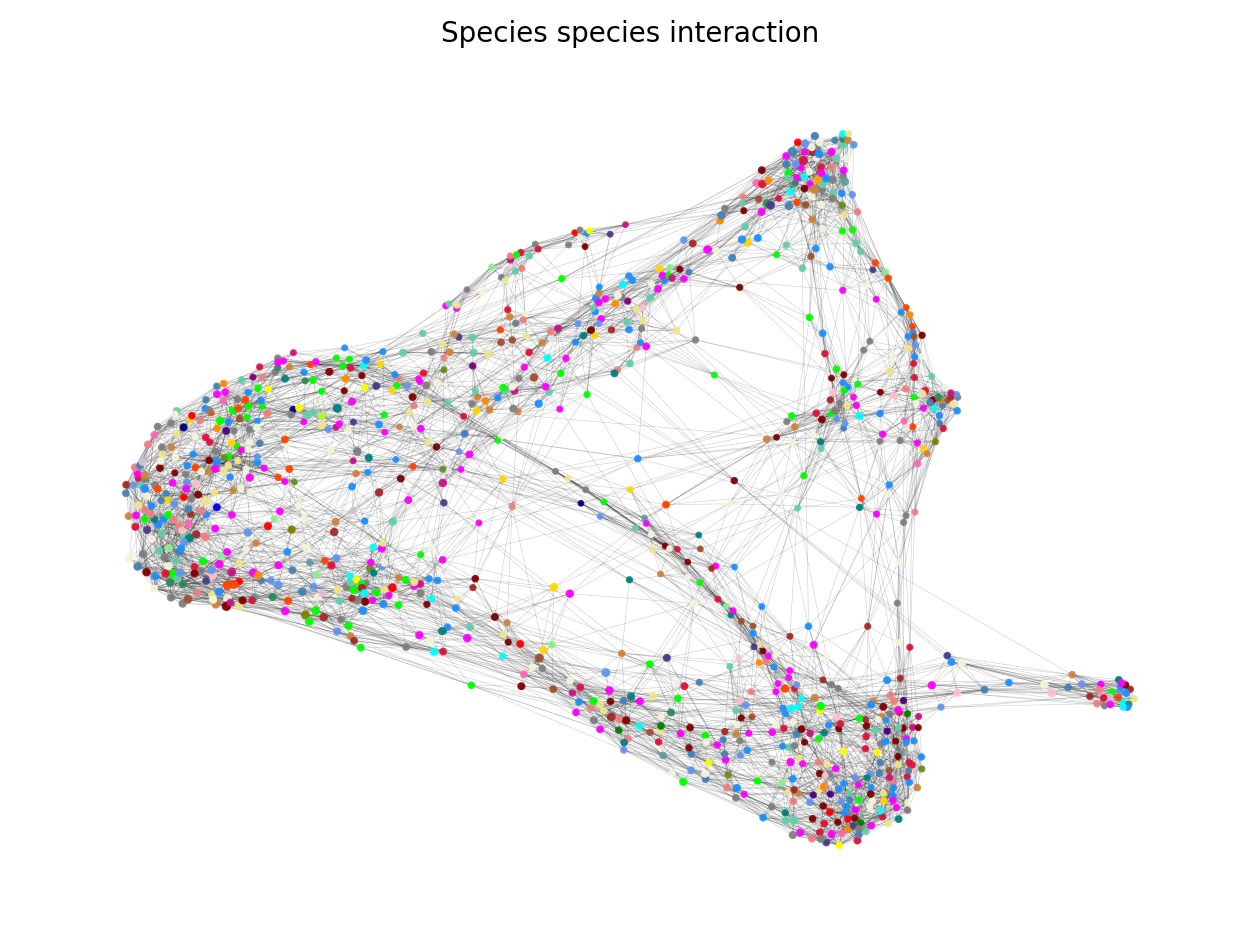

In [182]:
## Draw network plot 
if data == "original":
    n_size =  [np.log(g_sub.nodes[club]['Abundance']/139.0) for club in list(g_sub)]
    widths_n = weights = 2*np.array([g_sub[u][v]['weight'] for u,v in g_sub.edges()])
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    fnamex = figfol + 'species_interaction_mat1.pdf'
    fig, ax  = plt.subplots(dpi = 200)
    nx.draw_networkx_edges(g_sub, layout_flip, width=0.1*widths_n, alpha=0.2, ax =ax)
    nc = nx.draw_networkx_nodes(g_sub, 
                        layout_flip, 
                        nodelist=list(g_sub), 
                        node_size= 1*np.array(n_size), 
                        ax = ax,alpha = 0.9,
                        node_color=colors2)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPS1.png')
else: 
    n_size =  [np.log(g_sub.nodes[club]['Abundance']/139.0) for club in list(g_sub)]
    widths_n = weights = 2*np.array([g_sub[u][v]['weight'] for u,v in g_sub.edges()])
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    fnamex = figfol + 'species_interaction_mat1.pdf'
    fig, ax  = plt.subplots(dpi = 200)
    nx.draw_networkx_edges(g_sub, layout_flip, width=0.1*widths_n, alpha=0.2, ax =ax)
    nc = nx.draw_networkx_nodes(g_sub, 
                        layout_flip, 
                        nodelist=list(g_sub), 
                        node_size= 1*np.array(n_size), 
                        ax = ax,alpha = 0.9,
                        node_color=colors2)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPS1.png')

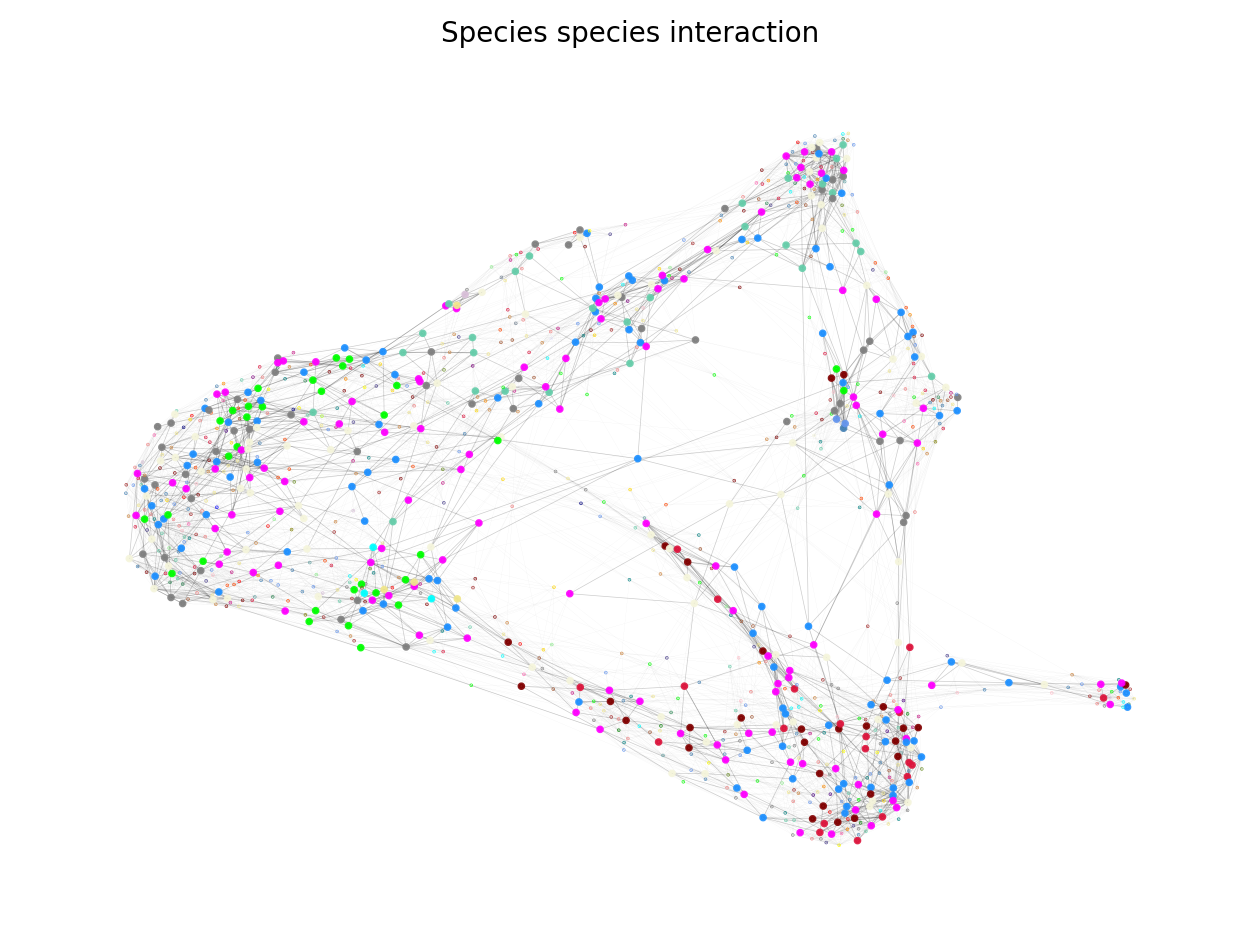

In [183]:
## Draw network plot 
if data == "original":
    n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
    n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
    e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])


    fnamex = figfol + 'species_interaction_mat1.pdf'
    fig, ax  = plt.subplots(dpi = 200)
    nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
    nc = nx.draw_networkx_nodes(g_sub, 
                        layout_flip, 
                        nodelist=list(g_sub), 
                        node_size= 3*np.array(n_size), 
                        ax = ax,alpha = 0.9,
                        node_color=colors2)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPS1.png')
else:
    n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
    n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
    e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])


    fnamex = figfol + 'species_interaction_mat1.pdf'
    fig, ax  = plt.subplots(dpi = 200)
    nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
    nc = nx.draw_networkx_nodes(g_sub, 
                        layout_flip, 
                        nodelist=list(g_sub), 
                        node_size= 3*np.array(n_size), 
                        ax = ax,alpha = 0.9,
                        node_color=colors2)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPS1.png')

<font color=blue>**Detect communities and highlight top species in each community. We have heilighted 807 species.**</font>

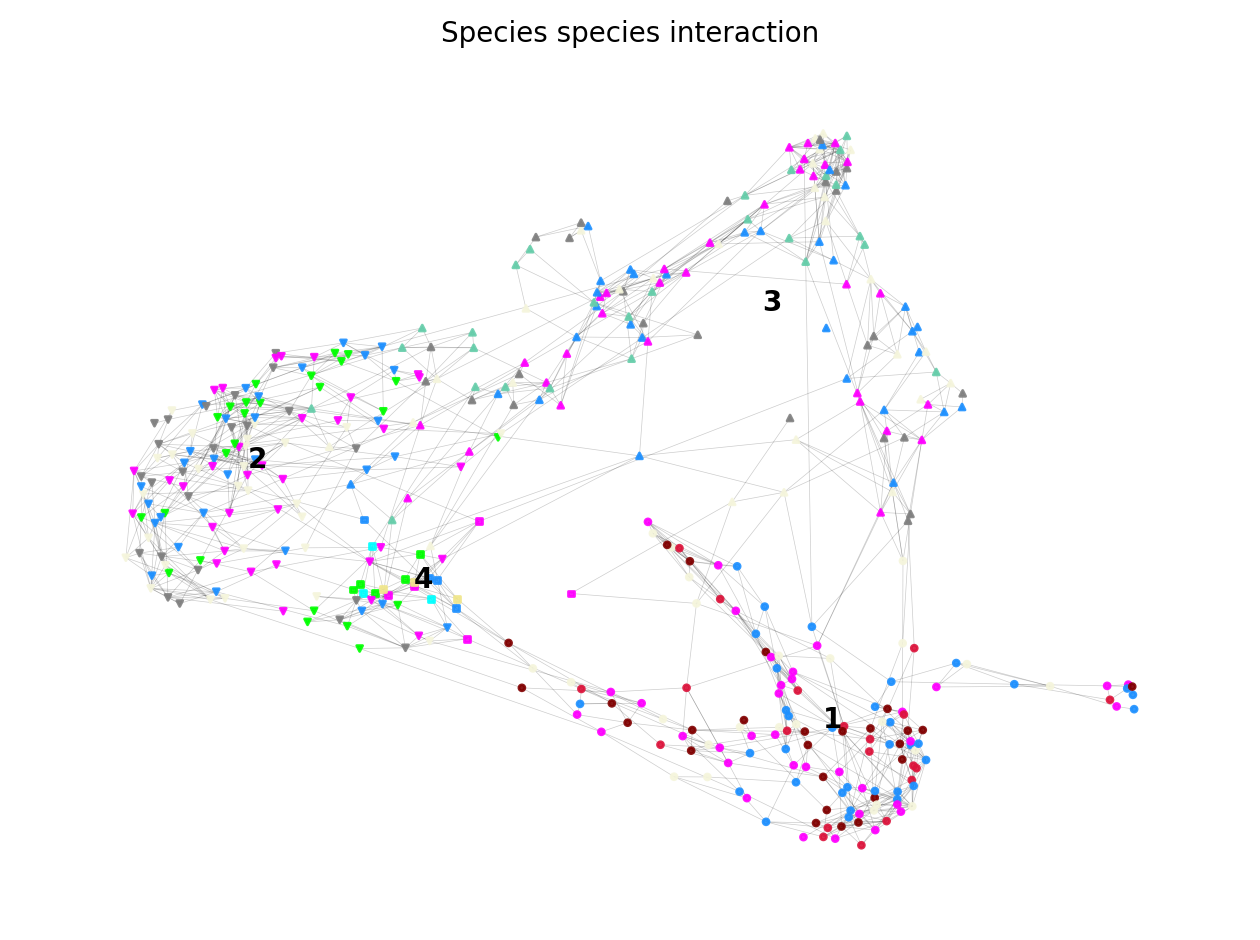

In [184]:
## Draw network plot 
from scipy.spatial import ConvexHull
if data == "original":
    n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
    n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
    e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])
    mtype = np.array([g_sub.nodes[n]['mtype'] for n in list(g_sub)])

    fig, ax  = plt.subplots(dpi = 200)
    for m_t in np.unique(mtype):
        sel_ind = np.where(mtype == m_t)
        nc = nx.draw_networkx_nodes(g_sub, 
                            layout_flip, 
                            nodelist= [list(g_sub)[i] for i in sel_ind[0]], 
                            node_size= 4.5*np.array(n_size)[sel_ind], 
                            ax = ax, alpha = 0.9,
                            node_shape = m_t,
                            node_color= [colors2[i] for i in sel_ind[0]])
        clust_cord = np.array([list(layout_flip[list(g_sub)[i]]) for i in sel_ind[0] if (list(g_sub)[i] in otu_sub)])
        xc, yc = np.median(clust_cord, axis = 0)
        val, cnt = np.unique(np.array(colors2)[sel_ind[0]], return_counts = True)
        hull = ConvexHull(clust_cord)
    #     ax.fill(clust_cord[hull.vertices,0], clust_cord[hull.vertices,1], val[cnt.argsort()][-1], alpha=0.05)
        ax.text(xc, yc, str(comunity2[list(g_sub)[sel_ind[0][0]]] + 1) , fontsize=10)
    #     for simplex in hull.simplices:
    #         ax.plot(clust_cord[simplex, 0], clust_cord[simplex, 1], 'k-', lw = 1, alpha = 0.5)
        
    nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPSx.png', dpi = 200)
else:
    g_sub = g.subgraph([n for n in g_sub.nodes if n in otu_sub]).copy()
    n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
    n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
    colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

    e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
    e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])
    mtype = np.array([g_sub.nodes[n]['mtype'] for n in list(g_sub)])

    fig, ax  = plt.subplots(dpi = 200)
    for m_t in np.unique(mtype):
        sel_ind = np.where(mtype == m_t)
        nc = nx.draw_networkx_nodes(g_sub, 
                            layout_flip, 
                            nodelist= [list(g_sub)[i] for i in sel_ind[0]], 
                            node_size= 4.5*np.array(n_size)[sel_ind], 
                            ax = ax, alpha = 0.9,
                            node_shape = m_t,
                            node_color= [colors2[i] for i in sel_ind[0]])
        clust_cord = np.array([list(layout_flip[list(g_sub)[i]]) for i in sel_ind[0] if (list(g_sub)[i] in otu_sub)])
        xc, yc = np.median(clust_cord, axis = 0)
        val, cnt = np.unique(np.array(colors2)[sel_ind[0]], return_counts = True)
        hull = ConvexHull(clust_cord)
        ax.text(xc, yc, str(comunity2[list(g_sub)[sel_ind[0][0]]] + 1) , fontsize=10)
        
    nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
    ax.axis('off')
    ax.set_title("Species species interaction", fontsize = 10)
    fig.tight_layout()
    fig.savefig(figfol + 'MI2SPSx.png', dpi = 200)

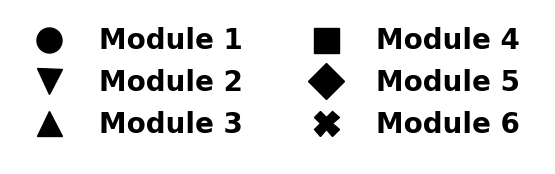

In [185]:
if data == "original":
    marker_dict = dict(zip(range(len(comunity)),markers_type[:len(comunity)]))
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    label = [ 'Module ' + str(i+1) for i in marker_dict.keys()]   
    fig, ax  = plt.subplots(dpi = 100, figsize = (6,2))
    handles = [f(marker_dict[i], 'black') for i in marker_dict.keys()]
    plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=2,markerscale=3., fontsize=18,  prop={'size': 20})
    plt.gca().set_axis_off()
    plt.show()
    fig.savefig(figfol + 'tempi.png')
else:
    marker_dict = dict(zip(range(len(comunity)),markers_type[:len(comunity)]))
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    label = [ 'Module ' + str(i+1) for i in marker_dict.keys()]   
    fig, ax  = plt.subplots(dpi = 100, figsize = (6,2))
    handles = [f(marker_dict[i], 'black') for i in marker_dict.keys()]
    plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=2,markerscale=3., fontsize=18,  prop={'size': 20})
    plt.gca().set_axis_off()
    plt.show()
    fig.savefig(figfol + 'tempi.png')

In [186]:
len(otu_sub)

441

### Prepare the table for the cluster and its properties 
We report top 3 OTUs in each cluster and report its characteristic. 

Draw legend for the plot and table of summary; [Community id, Top species, Counts, Name, Mean Abundance]

In [187]:
if data == "original":
    Summary_clust  = [[g_sub_c.nodes[n]['c_id']+1, g_sub_c.nodes[n]['ECR'], g_sub_c.nodes[n]['Abundance'] ] for n in list(g_sub_c)]
    Summary_clust = pd.DataFrame(Summary_clust)
    Summary_clust.columns = ['ClusterIndex', 'ECR', 'TotalAbundance']
    Summary_clust = Summary_clust[['ClusterIndex', 'ECR', 'TotalAbundance']].groupby(['ClusterIndex', 'ECR']).agg(['sum', 'count']).reset_index()
    Summary_clust.columns = ['ClusterIndex', 'ECR', 'MeanAbundance','OTU(Count)']
    Summary_clust['MeanAbundance'] = Summary_clust['MeanAbundance']/(139.0*Summary_clust['OTU(Count)'])
    Summary_clust = Summary_clust.round(2).sort_values(by=['ClusterIndex','OTU(Count)' ], ascending=[True, False])
    Summary_clust.iloc[:,3] = np.round(100.0*Summary_clust.iloc[:,3]/np.sum(Summary_clust.iloc[:,3]),2)
    Summary_clust.to_csv('clust_sumary.csv', index = False)
    Summary_clust
else: 
    Summary_clust  = [[g_sub_c.nodes[n]['c_id']+1, g_sub_c.nodes[n]['erc'], g_sub_c.nodes[n]['Abundance'] ] for n in list(g_sub_c)]
    Summary_clust = pd.DataFrame(Summary_clust)
    Summary_clust.columns = ['ClusterIndex', 'erc', 'TotalAbundance']
    Summary_clust = Summary_clust[['ClusterIndex', 'erc', 'TotalAbundance']].groupby(['ClusterIndex', 'erc']).agg(['sum', 'count']).reset_index()
    Summary_clust.columns = ['ClusterIndex', 'erc', 'MeanAbundance','OTU(Count)']
    Summary_clust['MeanAbundance'] = Summary_clust['MeanAbundance']/(139.0*Summary_clust['OTU(Count)'])
    Summary_clust = Summary_clust.round(2).sort_values(by=['ClusterIndex','OTU(Count)' ], ascending=[True, False])
    Summary_clust.iloc[:,3] = np.round(100.0*Summary_clust.iloc[:,3]/np.sum(Summary_clust.iloc[:,3]),2)
    Summary_clust.to_csv('clust_sumary.csv', index = False)
    Summary_clust

In [188]:
Summary_clust

,ClusterIndex,erc,MeanAbundance,OTU(Count)
1,1,Flavobacteriales,23.35,7.94
4,1,SAR11 clade,19.47,7.71
0,1,Alpha-other,18.15,5.90
2,1,Marinimicrobia (SAR406 clade),22.67,5.44
3,1,Poseidoniales (MGII Archaea),17.75,4.54
6,2,Flavobacteriales,31.76,7.71
9,2,SAR11 clade,28.78,6.80
8,2,Marinimicrobia (SAR406 clade),34.41,6.12
5,2,Chloroplast (unclassified),36.19,5.67
7,2,Gamma-other,33.55,5.44
